In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import tensorflow.keras as keras
from collections import OrderedDict

2022-06-26 20:44:30.877313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-26 20:44:30.877327: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path='/mnt/data1/prabhakaran/WeatherBench/netcdf/hr/'
cloud_cover_file='total_cloud_cover_1.40625deg/total_cloud_cover_2018_1.40625deg.nc'
total_precep_file = 'total_precipitation_1.40625deg/total_precipitation_2018_1.40625deg.nc'

cloud_cover_data = xr.open_dataset(path+cloud_cover_file)
total_precep_data = xr.open_dataset(path+total_precep_file)

In [3]:
cloud_cover_data
total_precep_data

<xarray.Dataset>
Dimensions:  (lon: 256, lat: 128, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 15:49:02 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

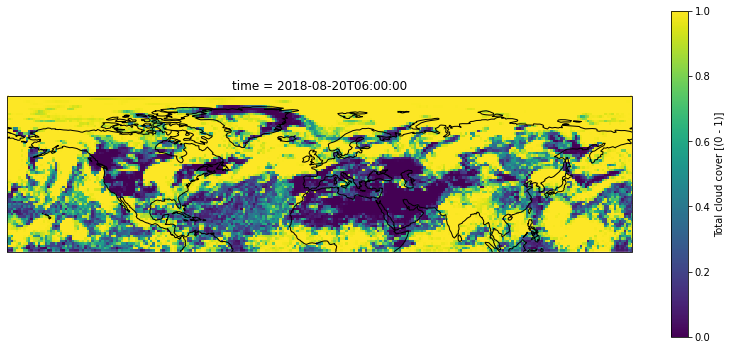

In [5]:
#plot for total cloud cover data
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cloud_cover_data.tcc[5550].plot.pcolormesh(
    ax=ax,x="lon", y="lat", transform=ccrs.PlateCarree(), add_colorbar=True
)
ax.coastlines()
ax.set_ylim([0, 90]);

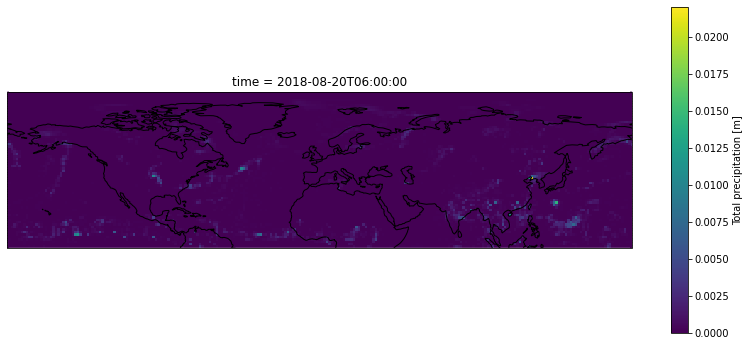

In [6]:
#plot for total precipitation
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
total_precep_data.tp[5550].plot.pcolormesh(
    ax=ax,x="lon", y="lat", transform=ccrs.PlateCarree(), add_colorbar=True
)
ax.coastlines()
ax.set_ylim([0, 90]);

In [4]:
#Dataset and Dataloader for cloud cover data and total precipitation data
cloud_cover_data_all=xr.open_mfdataset(path+'total_cloud_cover_1.40625deg/*.nc',combine='by_coords')
cloud_cover_data_all

total_precep_data_all=xr.open_mfdataset(path+'total_precipitation_1.40625deg/*.nc',combine='by_coords')
total_precep_data_all

<xarray.Dataset>
Dimensions:  (lon: 256, lat: 128, time: 350633)
Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(8753, 128, 256), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [4]:
 #subset of training data

 ds_train_cloud = cloud_cover_data_all.sel(time=slice('2015','2018'))
 ds_train_cloud

 ds_train_precepitation = total_precep_data_all.sel(time=slice('2015','2018'))
 ds_train_precepitation

<xarray.Dataset>
Dimensions:  (lon: 256, lat: 128, time: 35064)
Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * time     (time) datetime64[ns] 2015-01-01 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 128, 256), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [5]:
class XarrayDataset(Dataset):

    def __init__(self, data, mean= None, std= None):

        self.data = data

        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std

        # Normalize
        self.data = (self.data - self.mean) / self.std

        self.n_samples = self.data.isel(time=slice(0, -6)).shape[0]
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data.isel(time=idx).values



#ds = ds_train_cloud['tcc']
ds = cloud_cover_data_all['tcc']
my_ds = XarrayDataset(ds)

In [6]:
#Dataloader
my_dl = DataLoader(my_ds, 128, True)
i = iter(my_dl)
next(i)

tensor([[[-0.7997, -0.9033, -1.0183,  ..., -0.6289, -0.6880, -0.7434],
         [-1.0172, -0.4350,  0.1820,  ..., -0.8624, -0.6901, -0.8561],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         ...,
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455]],

        [[ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         ...,
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455]],

        [[ 1.0455,  1.0455,  1.0455,  ...,  1.0455,  1.0455,  1.0455],
         [ 1.0455,  1.0455,  1.0455,  ...,  1

In [7]:
my_ds.mean, my_ds.std


(<xarray.DataArray 'tcc' ()>
 array(0.6742168, dtype=float32),
 <xarray.DataArray 'tcc' ()>
 array(0.31159067, dtype=float32))